# import

In [1]:
import os
import time
import exrex
import random
import pickle
import numpy as np
from numpy.lib.stride_tricks import as_strided
import pandas as pd
from math import ceil
from faker import Faker
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from scipy.interpolate import interp1d
from scipy.stats import kstest, ks_2samp, chi2_contingency, wasserstein_distance, norm
import tensorflow as tf
from tensorflow.compat.v1.logging import set_verbosity, ERROR
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints, initializers
from sdv.metadata import MultiTableMetadata
from rdt import HyperTransformer
import rdt.transformers as rt
from tqdm import tqdm

In [2]:
fake = Faker('en-NZ')

In [3]:
set_verbosity(ERROR)

In [4]:
tf.random.set_seed(123)

In [5]:
tf.__version__

'2.6.0'

# load data

In [6]:
def load_data_collection(dir_path):
    gtfs_files = [f for f in os.listdir(dir_path) if f.endswith('.csv') or f.endswith('.txt')]
    data_collection = {}
    for f in gtfs_files:
        f_path = os.path.join(dir_path, f)
        data = pd.read_csv(f_path)
        if data.shape[0] > 1:
            data_collection[f.split(".")[0]] = data
    return data_collection

In [7]:
real_data_collection = load_data_collection("gtfs")

In [8]:
del real_data_collection['shapes']

# Setup Metadata (i.e. Schema)

## (Optional) Adjust Daylight-Savings Delta-Time to Traditional DateTime

In [9]:
def adjust_time(df, datetime_cols):
    for col in datetime_cols:
        df[col] = pd.to_timedelta(df[col])
        df[col] = df[col] % pd.Timedelta(days=1)
        df[col] = df[col].astype(str).str.split().str[-1]
    return df

In [10]:
sdv_metadata = MultiTableMetadata()

In [11]:
columns_to_remove = ['agency_name','agency_fare_url', 'agency_email']
real_data_collection['agency'].drop(columns_to_remove, axis=1, inplace=True)

In [12]:
sdv_metadata.detect_table_from_dataframe(table_name='agency', data=real_data_collection['agency'])
sdv_metadata.update_column(table_name='agency',column_name='agency_id',sdtype='id',regex_format='[A-Z]{2,5}')
sdv_metadata.update_column(table_name='agency',column_name='agency_url',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_timezone',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_lang',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_phone',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='agency',column_name='agency_id')

In [13]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar',data=real_data_collection['calendar'])
sdv_metadata.update_column(table_name='calendar',column_name='service_id',sdtype='id',regex_format='[a-zA-Z]{3,5}-\d{1,2}')
sdv_metadata.update_column(table_name='calendar',column_name='monday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='tuesday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='wednesday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='thursday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='friday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='saturday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='sunday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='start_date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.update_column(table_name='calendar',column_name='end_date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.set_primary_key(table_name='calendar',column_name='service_id')

In [14]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar_dates',data=real_data_collection['calendar_dates'])
sdv_metadata.update_column(table_name='calendar_dates',column_name='service_id',sdtype='id',regex_format='[a-zA-Z]{3,5}-\d{1,2}')
sdv_metadata.update_column(table_name='calendar_dates',column_name='date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.update_column(table_name='calendar_dates',column_name='exception_type',sdtype='categorical')

In [15]:
columns_to_remove = ['route_short_name','route_long_name','route_desc', 'route_url','route_sort_order']
real_data_collection['routes'].drop(columns_to_remove, axis=1, inplace=True)
real_data_collection['routes']['route_color'] = real_data_collection['routes']['route_color'].fillna('NA')
real_data_collection['routes']['route_text_color'] = real_data_collection['routes']['route_text_color'].fillna('NA')

In [16]:
sdv_metadata.detect_table_from_dataframe(table_name='routes',data=real_data_collection['routes'])
sdv_metadata.update_column(table_name='routes',column_name='route_id',sdtype='id',regex_format='[A-Z]{2,6}-\d{3}')
sdv_metadata.update_column(table_name='routes',column_name='agency_id',sdtype='id',regex_format='[A-Z]{2,5}')
sdv_metadata.update_column(table_name='routes',column_name='route_type',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_text_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='contract_id',sdtype='id',regex_format='([A-Z]{1,5}|\d{1,5})')
sdv_metadata.set_primary_key(table_name='routes',column_name='route_id')

In [17]:
columns_to_remove = ['stop_code','stop_name','stop_desc', 'zone_id','stop_url','stop_timezone']
real_data_collection['stops'].drop(columns_to_remove, axis=1, inplace=True)
real_data_collection['stops']['parent_station'] = real_data_collection['stops']['parent_station'].fillna('NA')
real_data_collection['stops']['platform_code'] = real_data_collection['stops']['platform_code'].fillna('NA')

In [18]:
sdv_metadata.detect_table_from_dataframe(table_name='stops',data=real_data_collection['stops'])
sdv_metadata.update_column(table_name='stops',column_name='stop_id',sdtype='id',regex_format='\d{4,5}-[a-z\d]{8}')
sdv_metadata.update_column(table_name='stops',column_name='stop_lat',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='stop_lon',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='location_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='parent_station',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='platform_code',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='wheelchair_boarding',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='start_date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.update_column(table_name='stops',column_name='end_date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.set_primary_key(table_name='stops',column_name='stop_id')

In [19]:
columns_to_remove = ['stop_headsign']
real_data_collection['stop_times'].drop(columns_to_remove, axis=1, inplace=True)
real_data_collection['stop_times'] = adjust_time(real_data_collection['stop_times'], ['arrival_time','departure_time'])

In [20]:
sdv_metadata.detect_table_from_dataframe(table_name='stop_times',data=real_data_collection['stop_times'])
sdv_metadata.update_column(table_name='stop_times',column_name='trip_id',sdtype='id',regex_format='\d{1,5}-\d{1,7}-\d{1,5}-2-[a-z\d]{1,8}(-[a-z\d]{1,8})?')
sdv_metadata.update_column(table_name='stop_times',column_name='arrival_time',sdtype='datetime',datetime_format='%H:%M:%S')
sdv_metadata.update_column(table_name='stop_times',column_name='departure_time',sdtype='datetime',datetime_format='%H:%M:%S')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_id',sdtype='id',regex_format='\d{4,5}-[a-z\d]{8}')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_sequence',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stop_times',column_name='pickup_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='drop_off_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='shape_dist_traveled',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stop_times',column_name='timepoint',sdtype='numerical',computer_representation='Int32')

In [21]:
columns_to_remove = ['trip_headsign','trip_short_name', 'block_id']
real_data_collection['trips'].drop(columns_to_remove, axis=1, inplace=True)

In [22]:
sdv_metadata.detect_table_from_dataframe(table_name='trips',data=real_data_collection['trips'])
sdv_metadata.update_column(table_name='trips',column_name='route_id',sdtype='id',regex_format='[A-Z]{2,6}-\d{3}')
sdv_metadata.update_column(table_name='trips',column_name='service_id',sdtype='id',regex_format='[a-zA-Z]{3,5}-\d{1,2}')
sdv_metadata.update_column(table_name='trips',column_name='trip_id',sdtype='id',regex_format='\d{1,5}-\d{1,7}-\d{1,5}-2-[a-z\d]{1,8}(-[a-z\d]{1,8})?')
sdv_metadata.update_column(table_name='trips',column_name='direction_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='shape_id',sdtype='id',regex_format='\d{1,4}-\d{5,6}-[a-z\d]{8}')
sdv_metadata.update_column(table_name='trips',column_name='wheelchair_accessible',sdtype='categorical')
sdv_metadata.update_column(table_name='trips',column_name='bikes_allowed',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='trips',column_name='trip_id')

In [23]:
sdv_metadata.add_relationship(
    parent_table_name='agency',
    child_table_name='routes',
    parent_primary_key='agency_id',
    child_foreign_key='agency_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='calendar_dates',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='trips',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='routes',
    child_table_name='trips',
    parent_primary_key='route_id',
    child_foreign_key='route_id'
)

sdv_metadata.add_relationship(
    parent_table_name='stops',
    child_table_name='stop_times',
    parent_primary_key='stop_id',
    child_foreign_key='stop_id'
)

sdv_metadata.add_relationship(
    parent_table_name='trips',
    child_table_name='stop_times',
    parent_primary_key='trip_id',
    child_foreign_key='trip_id'
)

In [24]:
sdv_metadata.validate()

## (Optional) View Inter-Table Structure

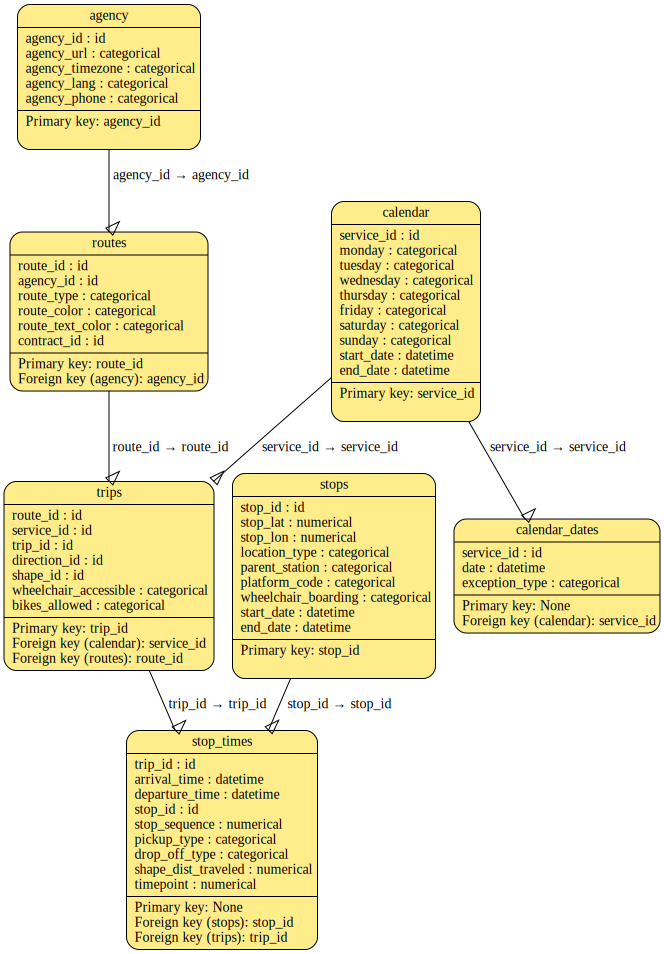

In [25]:
sdv_metadata.visualize(output_filepath='visualization/gtfs.jpeg')

# Preprocessing

In [26]:
training_start_time = time.time()

## Create Modelling Metadata

Setup dictionary for identifying the primary key, parent(s), child(ren) and foreign key(s) of each table.

In [27]:
def sdvmetadata_to_modelmetadata(sdv_metadata):
    modelling_metadata = {}
    for df_name, content in sdv_metadata["tables"].items():
        modelling_metadata[df_name] = {
            "primary_key": content.get("primary_key"),
            "parent": {},
            "child": {},
            "is_sequential": False,
            "sort_order":None,
            "step_index":None
        }
    for relationship in sdv_metadata["relationships"]:
        parent_table = relationship["parent_table_name"]
        child_table = relationship["child_table_name"]
        foreign_key = relationship["child_foreign_key"]
        modelling_metadata[child_table]["parent"][parent_table] = foreign_key
        modelling_metadata[parent_table]["child"][child_table] = foreign_key
    return modelling_metadata

In [28]:
modelling_metadata = sdvmetadata_to_modelmetadata(sdv_metadata.to_dict())

In [29]:
modelling_metadata['calendar_dates']['is_sequential']=True
modelling_metadata['calendar_dates']['sort_order']=['service_id','date']
modelling_metadata['calendar_dates']['step_index']=['date']
modelling_metadata['stop_times']['is_sequential']=True
modelling_metadata['stop_times']['sort_order']=['trip_id','stop_sequence']
modelling_metadata['stop_times']['step_index']=['stop_sequence']

## Fit RDT Transformers and Formatters

Use tools from RDT package to convert data to solely numeric and back-transforming to the original format.

In [30]:
def create_formatter_collection(data_collection):
    formatter_collection = {}
    for df_name, df in data_collection.items():
        ht = HyperTransformer()
        ht.detect_initial_config(df)
        ht.update_transformers_by_sdtype(
            sdtype='categorical',
            transformer_name='LabelEncoder'
        )
        # ht.update_transformers_by_sdtype(
        #     sdtype='datetime',
        #     transformer_name='OptimizedTimestampEncoder'
        # )
        # ht.update_transformers_by_sdtype(
        #     sdtype='numerical',
        #     transformer_name='FloatFormatter'
        # )
        ht.fit(df)
        formatter_collection[df_name] = ht
    return formatter_collection

In [31]:
%%time
formatter_collection = create_formatter_collection(real_data_collection)

CPU times: total: 3.03 s
Wall time: 3.04 s


### (Optional) Adjust Incorrectly Detected Column Types from RDT's Auto-Detection

In [32]:
formatter_collection['stop_times'].get_config()

{
    "sdtypes": {
        "trip_id": "categorical",
        "arrival_time": "categorical",
        "departure_time": "categorical",
        "stop_id": "categorical",
        "stop_sequence": "numerical",
        "pickup_type": "numerical",
        "drop_off_type": "numerical",
        "shape_dist_traveled": "numerical",
        "timepoint": "numerical"
    },
    "transformers": {
        "trip_id": LabelEncoder(),
        "arrival_time": LabelEncoder(),
        "departure_time": LabelEncoder(),
        "stop_id": LabelEncoder(),
        "stop_sequence": FloatFormatter(),
        "pickup_type": FloatFormatter(),
        "drop_off_type": FloatFormatter(),
        "shape_dist_traveled": FloatFormatter(),
        "timepoint": FloatFormatter()
    }
}

In [33]:
formatter_collection['stop_times'].update_sdtypes(column_name_to_sdtype={
    'pickup_type':'categorical',
    'drop_off_type':'categorical'
})
formatter_collection['stop_times'].update_transformers_by_sdtype(
    sdtype='categorical',
    transformer_name='LabelEncoder'
)
formatter_collection['stop_times'].fit(real_data_collection['stop_times'])

C:\programs\conda\envs\tfgpu\lib\site-packages\rdt\hyper_transformer.py:390: UserWarning: For this change to take effect, please refit your data using 'fit' or 'fit_transform'.
  warnings.warn(self._REFIT_MESSAGE)
C:\programs\conda\envs\tfgpu\lib\site-packages\rdt\hyper_transformer.py:299: UserWarning: For this change to take effect, please refit your data using 'fit' or 'fit_transform'.
  warnings.warn(self._REFIT_MESSAGE)


## Transform Data to Numeric

In [34]:
def batch_transform(modelling_metadata, df_dict, ht_dict):
    # Initialize the dictionary that will store the mappings for each primary key
    primary_key_dict = {}

    # Initialize a new dictionary to store the transformed dataframes
    transformed_df_dict = {table: df.copy() for table, df in df_dict.items()}

    # Initialize the dictionary to store transform methods
    transform_method_dict = {table: {'labels': [], 'table': []} for table in df_dict.keys()}

    # 1st pass: Fit the HT objects for all tables
    for df_name, content in modelling_metadata.items():
        ht = ht_dict[df_name]
        ht.fit(transformed_df_dict[df_name])  # Fit the HT object on the entire table

    # 2nd pass: factorize primary keys and build the global primary key dictionary
    for df_name, content in modelling_metadata.items():
        primary_key = content['primary_key']
        if primary_key is not None:  # Skip tables without a primary key
            transformed_df_dict[df_name][primary_key], unique = pd.factorize(transformed_df_dict[df_name][primary_key])
            primary_key_dict[df_name] = {primary_key: {key: value for value, key in enumerate(unique)}}
            transform_method_dict[df_name]['labels'].append(primary_key)

    # 3rd pass: replace foreign keys using the primary key dictionary
    for df_name, content in modelling_metadata.items():
        for parent_table, foreign_key in content['parent'].items():
            primary_key = modelling_metadata[parent_table]['primary_key']
            transformed_df_dict[df_name][foreign_key] = transformed_df_dict[df_name][foreign_key].map(primary_key_dict[parent_table][primary_key])
            transform_method_dict[df_name]['labels'].append(foreign_key)

    # 4th pass: transform the remaining columns with the fitted HT objects
    for df_name, content in modelling_metadata.items():
        ht = ht_dict[df_name]
        df = transformed_df_dict[df_name]
        remaining_cols = [col for col in df.columns if col not in transform_method_dict[df_name]['labels']]
        if remaining_cols:
            df[remaining_cols] = ht.transform_subset(df[remaining_cols])  # Transform only the remaining columns
            transform_method_dict[df_name]['table'].extend(remaining_cols)

    return transformed_df_dict, transform_method_dict

In [35]:
%%time
transformed_data_collection, transform_method_dict = batch_transform(modelling_metadata, real_data_collection, formatter_collection)

CPU times: total: 4.67 s
Wall time: 4.68 s


## Split Tables into Discrete and Continuous Columns

In [36]:
def identify_columns(sdv_metadata, modelling_metadata):
    # Define the discrete types.
    discrete_sdtypes = ['categorical', 'id', 'boolean']

    # Iterate over the metadata.
    for df_name, content in sdv_metadata.items():
        grouped_columns = {'categorical': [], 'numeric': []}
        # Iterate over the columns of the DataFrame.
        for column_name, col_type in content['columns'].items():
            # If the column's 'sdtype' is one of the discrete types, add it to the 'discrete' group.
            if col_type['sdtype'] in discrete_sdtypes:
                grouped_columns['categorical'].append(column_name)
            # elif col_type['sdtype'] == 'numerical':
            #     if 'computer_representation' in col_type and 'Int' in col_type['computer_representation']:
            #         grouped_columns['discrete'].append(column_name)
            else:
                # Otherwise, add it to the 'continuous' group.
                grouped_columns['numeric'].append(column_name)
        modelling_metadata[df_name]['col_types'] = grouped_columns

In [37]:
identify_columns(sdv_metadata.to_dict()['tables'], modelling_metadata)

In [38]:
def split_continuous_discrete(data_collection, modelling_metadata):
    for df_name, content in modelling_metadata.items():
        foreign_columns = []
        label_columns = []
        selected_columns = []
        if content['parent'] != {}:
            foreign_columns = list(modelling_metadata[df_name]['parent'].values())
        discrete_columns = modelling_metadata[df_name]['col_types']['categorical']
        if content['primary_key'] != None:
            selected_columns = [col for col in discrete_columns if col != content['primary_key']]
        else:
            selected_columns = discrete_columns
        selected_columns = list(set(foreign_columns) | set(selected_columns))
        if content['step_index'] != None:
            selected_columns = list(set(content['step_index']) | set(selected_columns))
        if selected_columns != [] or None:
            modelling_metadata[df_name]['selected_columns'] = selected_columns
        else:
            modelling_metadata[df_name]['selected_columns'] = []

In [39]:
%%time
split_continuous_discrete(transformed_data_collection, modelling_metadata)

CPU times: total: 0 ns
Wall time: 0 ns


## Scaling

In [40]:
# def n_unique_elements(data):
#     unique_counts = data.nunique()
#     unique_dict = unique_counts.to_dict()
#     return unique_dict

In [41]:
def get_min_max_range(df):
    min_max_range = {}
    for col in df.columns:
        min_ = df[col].min()
        max_ = df[col].max()
        min_max_range[col] = {'min':min_,'max':max_}
    return min_max_range

In [42]:
def normal_scaling(df):
    scaler = StandardScaler()
    scaler = scaler.fit(df)
    scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    return scaled_df, scaler

In [43]:
def extract_key_and_scaled_features(df, label_columns):
    labels = df[label_columns]
    table = df.drop(columns=label_columns)
    table_column_names = table.columns
    try:
        scaled_table, table_scaler = normal_scaling(table)
    except:
        scaled_table = None
        table_scaler = None
    scaled_labels, labels_scaler = normal_scaling(labels)
    return scaled_table, scaled_labels, table_scaler, labels_scaler, table_column_names

In [44]:
def batch_scaling(data_collection, modelling_metadata):
    processed_data_collection = {}
    backtransformation_dict = {}
    for df_name, df in data_collection.items():
        selected_columns = modelling_metadata[df_name]['selected_columns']
        primary_key_column = modelling_metadata[df_name]['primary_key']
        if primary_key_column != None:
            label_columns = list(set([primary_key_column]) | set(selected_columns))
        else:
            label_columns = selected_columns
            primary_key_scaler = None
        table, labels, table_scaler, labels_scaler, table_columns = extract_key_and_scaled_features(df, label_columns)
        processed_data_collection[df_name] = {'table':table,
                                              'labels':labels}
        backtransformation_dict[df_name] = {'table_scaler':table_scaler,
                                            'labels_scaler':labels_scaler,
                                       'table_col_names':table_columns,
                                       'labels_col_names':label_columns,
                                       'col_names':df.columns,
                                           'min_max_range':get_min_max_range(df[selected_columns])}
    return processed_data_collection, backtransformation_dict

In [45]:
%%time
processed_data_collection, backtransformation_dict = batch_scaling(transformed_data_collection, modelling_metadata)

CPU times: total: 281 ms
Wall time: 293 ms


# Modelling

## Fit KDE

In [46]:
def fit_kde(data, kernel='tophat', bandwidth='scott'):
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(data)
    return kde

In [47]:
def batch_kde_fitting(data_collection, modelling_metadata):
    kde_collection = {}
    for df_name, df in data_collection.items():
        selected_columns = modelling_metadata[df_name]['selected_columns']
        if selected_columns != []:
            kde = fit_kde(df[selected_columns])
            kde_collection[df_name] = kde
    return kde_collection

In [48]:
%%time
kde_collection = batch_kde_fitting(transformed_data_collection, modelling_metadata)

CPU times: total: 1.78 s
Wall time: 1.77 s


## Build GAN

### Create Custom Functions for WGAN+GP Framework

In [49]:
def generator_loss(x_fake):
    return -tf.reduce_mean(x_fake)

In [50]:
def discriminator_loss(x_real, x_fake):
    real_loss = tf.reduce_mean(x_real)
    fake_loss = tf.reduce_mean(x_fake)
    return fake_loss - real_loss

In [51]:
def gradient_penalty(batch_size, real_table, fake_table, real_labels, discriminator, window=None):
    alpha = np.random.normal(0, 1, [batch_size, window, real_table.shape[2]])
    diff = tf.convert_to_tensor(fake_table) - real_table
    interpolated_table = real_table + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated_table)
        pred = discriminator([interpolated_table,real_labels], training=True)

    grads = gp_tape.gradient(pred, [interpolated_table])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

In [52]:
class CustomSlidingWindow:
    def __init__(self, window_size):
        self.window_size = window_size

    def transform(self, data):
        shape = (data.shape[0] - self.window_size + 1, self.window_size) + data.shape[1:]
        strides = (data.strides[0],) + data.strides
        return as_strided(data, shape=shape, strides=strides)

    def inverse_transform(self, data, use_mean=False):
        if use_mean:
            rows, _, cols = data.shape
            output = np.zeros((rows+self.window_size-1, cols))
            count = np.zeros((rows+self.window_size-1, cols))
            
            for i, window in enumerate(data):
                for j, row in enumerate(window):
                    output[i+j] += row
                    count[i+j] += 1

            return output / count
        else:
            return data[:, 0, :]

### Define Plotting Function For G/D Loss

In [53]:
def plot_history(logs):
    n = len(logs)
    n_rows = (n + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, (model_name, generator_log, discriminator_log) in enumerate(logs):
        axes[i].plot(generator_log, label='GLoss')
        axes[i].plot(discriminator_log, label='DLoss')
        axes[i].legend()
        axes[i].set_title(model_name)

    for i in range(n, n_rows * 3):
        axes[i].remove()

    plt.tight_layout()
    plt.show()
    plt.close()

### Define Generator, discriminator and GAN Architecture

In [54]:
def build_conv_generator(table_dim, labels_dim, window, opt, loss, latent_dim=100):
    noise_input = layers.Input(shape=(window,latent_dim,))
    labels_input = layers.Input(shape=(window,labels_dim,))
    merge_input = layers.Concatenate()([noise_input, labels_input])
    hidden_layer1 = layers.Conv1DTranspose(256,kernel_size=3,activation='relu',kernel_initializer='he_normal',padding='same')(merge_input)
    bn_layer1 = layers.BatchNormalization()(hidden_layer1)
    hidden_layer2 = layers.Conv1DTranspose(128,kernel_size=4,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer2)
    hidden_layer3 = layers.Conv1DTranspose(64,kernel_size=5,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer2)
    bn_layer3 = layers.BatchNormalization()(hidden_layer3)
    hidden_layer4 = layers.Conv1DTranspose(32,kernel_size=6,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer3)
    bn_layer4 = layers.BatchNormalization()(hidden_layer4)
    output_layer = layers.Conv1DTranspose(table_dim,kernel_size=1,activation='linear',kernel_initializer='glorot_normal')(bn_layer4)
    generator = models.Model([noise_input, labels_input], output_layer)
    generator.compile(optimizer=opt, loss=loss)
    return generator

In [55]:
def build_conv_discriminator(table_dim, labels_dim, window, opt, loss):
    table_input = layers.Input(shape=(window,table_dim,))
    labels_input = layers.Input(shape=(window,labels_dim,))
    merge_input = layers.Concatenate()([table_input, labels_input])
    hidden_layer1 = layers.Conv1D(32,kernel_size=6,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same')(merge_input)
    bn_layer1 = layers.BatchNormalization()(hidden_layer1)
    dropout1 = layers.Dropout(0.3)(bn_layer1)
    hidden_layer2 = layers.Conv1D(64,kernel_size=5,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same')(dropout1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer2)
    dropout2 = layers.Dropout(0.3)(bn_layer2)
    hidden_layer3 = layers.Conv1D(128,kernel_size=4,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same')(dropout2)
    bn_layer3 = layers.BatchNormalization()(hidden_layer3)
    dropout3 = layers.Dropout(0.3)(bn_layer3)
    hidden_layer4 = layers.Conv1D(256,kernel_size=3,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same')(dropout3)
    bn_layer4 = layers.BatchNormalization()(hidden_layer4)
    dropout4 = layers.Dropout(0.3)(bn_layer4)
    flatten = layers.Flatten()(dropout4)
    output_layer = layers.Dense(1, activation='linear',kernel_initializer='glorot_normal')(flatten)
    discriminator = models.Model([table_input, labels_input], output_layer)
    discriminator.compile(optimizer=opt, loss=loss)
    return discriminator

### Define Training Strategy

In [56]:
def train_gan(name, real_table, real_labels, window, n_discriminator=5, gp_weight=10, epochs=50, patience=10, min_delta=0.1, batch_size=400, latent_dim=100, seed=123):
    rand_seed = seed
    csw = CustomSlidingWindow(window)
    real_table = csw.transform(real_table.values)
    real_labels = csw.transform(real_labels.values)
    half_batch = int(batch_size/2)
    g_opt = optimizers.Adam()
    d_opt = optimizers.Adam()
    g_loss_func = generator_loss
    d_loss_func = discriminator_loss
    generator = build_conv_generator(real_table.shape[2], real_labels.shape[2], window=window, opt=g_opt, loss=g_loss_func, latent_dim=latent_dim)
    discriminator = build_conv_discriminator(real_table.shape[2], real_labels.shape[2], window=window, opt=d_opt, loss=d_loss_func)

    generator_logs = []
    discriminator_logs = []
    
    for epoch in tqdm(range(epochs), desc="Training Numeric GAN"):
        # start_time = time.time()
        
        # train discriminator:
        for _ in range(n_discriminator):
            np.random.seed(rand_seed)
            idx = np.random.randint(0, real_table.shape[0], half_batch)
            x_real_labels = real_labels[idx,:,:]
            x_real_table = real_table[idx,:,:]
            with tf.GradientTape() as tape:
                noise = np.random.normal(0, 1, (half_batch, window, latent_dim))
                x_fake_table = generator([noise, x_real_labels], training=True)
                d_logits_real = discriminator([x_real_table, x_real_labels], training=True)
                d_logits_fake = discriminator([x_fake_table, x_real_labels], training=True)
                d_cost = d_loss_func(d_logits_real, d_logits_fake)
                gp = gradient_penalty(half_batch, x_real_table, x_fake_table, x_real_labels, discriminator, window=window)
                d_loss = d_cost + gp * gp_weight
                rand_seed += 1
                
            d_grad = tape.gradient(d_loss, discriminator.trainable_variables)
            d_opt.apply_gradients(
                zip(d_grad, discriminator.trainable_variables)
            )
        d_loss = np.mean(d_loss)
        
        np.random.seed(rand_seed)
        # train generator/GAN
        idx = np.random.randint(0, real_table.shape[0], batch_size)
        x_real_labels = real_labels[idx,:,:]
        x_gan = np.random.normal(0, 1, (batch_size, window, latent_dim))
        with tf.GradientTape() as tape:
            x_fake_table = generator([x_gan, x_real_labels], training=True)
            g_logits = discriminator([x_fake_table, x_real_labels], training=True)
            g_loss = g_loss_func(g_logits)
        g_grad = tape.gradient(g_loss, generator.trainable_variables)
        g_opt.apply_gradients(
            zip(g_grad, generator.trainable_variables)
        )
        generator_logs.append(g_loss)
        discriminator_logs.append(d_loss)
        
        rand_seed += 1
        
    generator.save('models/'+name+'_gen.h5')
    
    return generator_logs, discriminator_logs

In [57]:
def collection_training(processed_collection, modelling_metadata, training_parameter_dict):
    logs = []
    init_time = time.time()
    for df_name, content in processed_collection.items():
        start_time = time.time()
        print(f'Learning Numeric Columns in \"{df_name}\"...')
        latent_dim = 100
        if content['table'] is not None:
            window=6
            modelling_metadata[df_name]['window'] = window
            generator_log, discriminator_log = train_gan(df_name,
                                                             content['table'],
                                                             content['labels'],
                                                             window=window,
                                                             epochs=training_parameter_dict[df_name]['epochs'],
                                                             latent_dim = latent_dim)
            logs.append([df_name, generator_log, discriminator_log])
            in_loop_elapsed_time = time.time() - start_time
            minutes, seconds = divmod(in_loop_elapsed_time, 60)
            print("Time Used: %dm %ds." % (minutes, seconds))
        else:
            modelling_metadata[df_name]['window'] = 0
            print("Skipped (fully-categorical table, fitted with KDE instead).")
        print()
    plot_history(logs)
    total_elapsed_time = time.time() - init_time
    minutes, seconds = divmod(total_elapsed_time, 60)
    print("Total Time Used: %dm %ds" % (minutes, seconds))

## Train GAN

In [58]:
def calculate_epochs(data_collection, batch_size=400):
    parameter_dict = {}
    for df_name, df in data_collection.items():
        epochs = len(df) / batch_size
        if epochs < 20:
            epochs = 20
        elif epochs > 500:
            epochs = 500
        parameter_dict[df_name] = {'epochs':round(epochs)}
    return parameter_dict

In [59]:
training_parameter_dict = calculate_epochs(transformed_data_collection)

In [60]:
training_parameter_dict

{'agency': {'epochs': 20},
 'calendar': {'epochs': 20},
 'calendar_dates': {'epochs': 20},
 'routes': {'epochs': 20},
 'stops': {'epochs': 20},
 'stop_times': {'epochs': 500},
 'trips': {'epochs': 81}}

Learning Numeric Columns in "agency"...
Skipped (fully-categorical table, fitted with KDE instead).

Learning Numeric Columns in "calendar"...


Training Numeric GAN: 100%|████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.27it/s]


Time Used: 0m 16s.

Learning Numeric Columns in "calendar_dates"...
Skipped (fully-categorical table, fitted with KDE instead).

Learning Numeric Columns in "routes"...
Skipped (fully-categorical table, fitted with KDE instead).

Learning Numeric Columns in "stops"...


Training Numeric GAN: 100%|████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]


Time Used: 0m 12s.

Learning Numeric Columns in "stop_times"...


Training Numeric GAN: 100%|██████████████████████████████████████████████████████████| 500/500 [05:01<00:00,  1.66it/s]


Time Used: 5m 1s.

Learning Numeric Columns in "trips"...
Skipped (fully-categorical table, fitted with KDE instead).



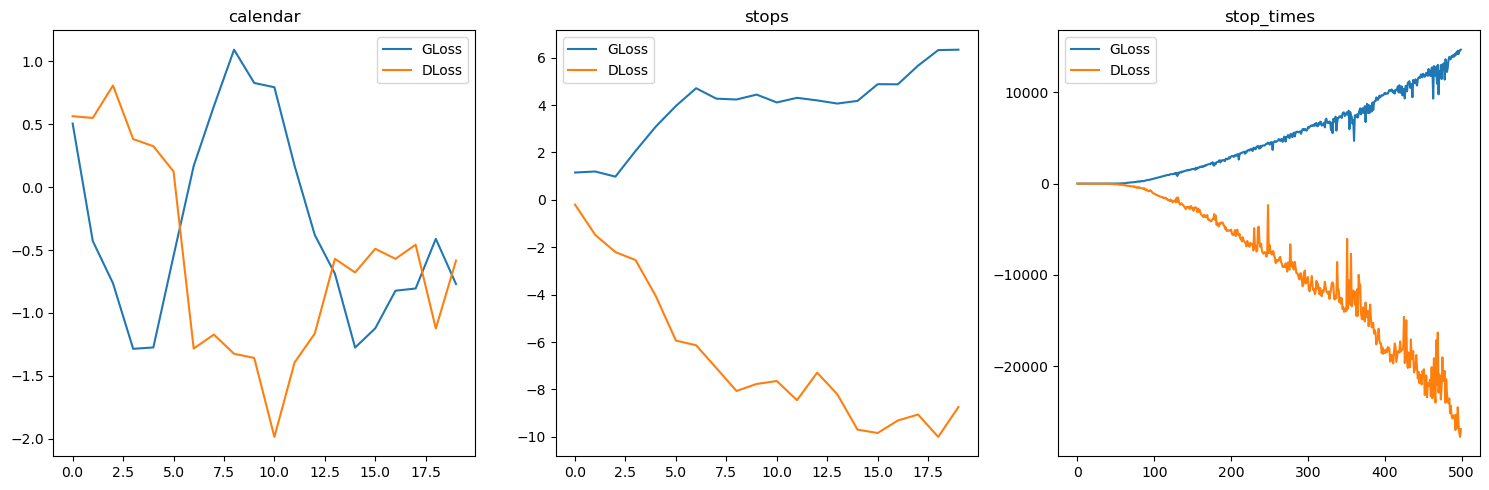

Total Time Used: 5m 31s
CPU times: total: 5min 33s
Wall time: 5min 31s


In [61]:
%%time

collection_training(processed_data_collection, modelling_metadata, training_parameter_dict)

In [62]:
training_end_time = time.time()
training_end_time = training_end_time - training_start_time
minutes, seconds = divmod(training_end_time, 60)
print(f'Total Training Time: {minutes}m {seconds}s.')

Total Training Time: 5.0m 44.60141205787659s.


In [63]:
generation_start_time = time.time()

## Set the number of rows to generate.

In [64]:
generation_dict = {k:{'nrows':len(v)} for k,v in real_data_collection.items()}

In [65]:
generation_dict

{'agency': {'nrows': 15},
 'calendar': {'nrows': 121},
 'calendar_dates': {'nrows': 674},
 'routes': {'nrows': 215},
 'stops': {'nrows': 6714},
 'stop_times': {'nrows': 966790},
 'trips': {'nrows': 32403}}

In [66]:
with open('pkl/gtfs/real_data_collection.pkl', 'wb') as f:
    pickle.dump(real_data_collection, f)

In [67]:
del real_data_collection

In [68]:
del transformed_data_collection

In [69]:
del processed_data_collection

# Synthetic Data Generation

## Define Interpolation Function

In [70]:
# def adjust_unique_elements(data, min_max_range, ignore=[]):
#     for col, range_ in min_max_range.items():
#         if col not in ignore:
#             data[col] = data[col]
#             min_val, max_val = data[col].min(), data[col].max()
#             original_range = np.linspace(min_val, max_val, len(data))
#             new_range = np.arange(range_['min'],range_['max'])
#             interp_func = interp1d(original_range, new_range, kind='nearest', bounds_error=False, fill_value=(range_['min'], range_['max']))
#             data[col] = interp_func(data[col]).astype(int)
#     return data

In [71]:
def adjust_unique_elements(df, min_max_range, ignore=[]):
    df_scaled = df.copy()
    for col, range_ in min_max_range.items():
        if col not in ignore:
            interpolator = interp1d([df[col].min(), df[col].max()], [range_['min'], range_['max']], kind='slinear', fill_value=(range_['min'], range_['max']))
            df_scaled[col] = interpolator(df[col]).round()
    return df_scaled

## Define KDE Sampling Strategy

In [72]:
def generate_labels(kde, n_samples, col_names, round_=False):
    new_data = kde.sample(n_samples)
    if round_:
        new_data_df = pd.DataFrame(new_data, columns=col_names).round()
    else:
        new_data_df = pd.DataFrame(new_data, columns=col_names)
    return new_data_df

## Generate Synthetic Data

In [73]:
def generate_synth_data_collection(kde_collection, modelling_metadata, generation_dict, backtransformation_dict, formatter_collection, transform_method_dict, latent_dim=100, seed=123):
    np.random.seed(seed)
    synthetic_data_collection = {}
    custom_objects = {'generator_loss':generator_loss}
    for df_name, content in modelling_metadata.items():
        if len(backtransformation_dict[df_name]['table_col_names']) != 0:
            generator = models.load_model('models/'+df_name+'_gen.h5', custom_objects=custom_objects)
        else:
            generator = None
        primary_key = content['primary_key']
        child = content['child']
        parent = content['parent']
        n_samples = generation_dict[df_name]['nrows']
        window = content['window']
        
        print(f"Generating {df_name} (size={n_samples})...")
        
        fake_primary_key = None
        fake_selected_columns = None
        if primary_key != None:
            fake_primary_key = np.arange(n_samples)
            fake_primary_key = pd.DataFrame({primary_key:fake_primary_key})
            
        if content['selected_columns'] != []:
            kde = kde_collection[df_name]
            print(f"Generating Key and Categorical Columns...")
            kde_start_time = time.time()
            fake_selected_columns = generate_labels(kde, n_samples, content['selected_columns'])
            kde_elapsed_time= time.time() - kde_start_time
            minutes, seconds = divmod(kde_elapsed_time, 60)
            print("Key and Categorical Columns Generated: %dm %ds." % (minutes, seconds))
            min_max_range = backtransformation_dict[df_name]['min_max_range']
            if parent != None:
                for parent_table, f_keys in parent.items():
                    min_max_range[f_keys] = {'min':0,'max':generation_dict[parent_table]['nrows']-1}
                fake_selected_columns = adjust_unique_elements(fake_selected_columns, min_max_range)
            else:
                fake_selected_columns = adjust_unique_elements(fake_selected_columns, min_max_range)
        
        if fake_primary_key is not None:
            if fake_selected_columns is not None:
                fake_labels = pd.concat([fake_primary_key, fake_selected_columns], axis=1)
            else:
                fake_labels = fake_primary_key
        else:
            fake_labels = fake_selected_columns
        
        fake_labels = fake_labels.reindex(columns=backtransformation_dict[df_name]['labels_col_names'])
        if content['is_sequential'] == True:
            fake_labels = fake_labels.sort_values(by=content['sort_order'])
            
        scaled_fake_labels = backtransformation_dict[df_name]['labels_scaler'].transform(fake_labels)
        
        if generator is not None:
            latent_dim = 100
            noise = np.random.normal(0, 1, size=(n_samples-window+1, window, latent_dim))
            print(f"Generating Numeric Columns...")
            generator_start_time=time.time()
            sw = CustomSlidingWindow(window)
            scaled_fake_labels = sw.transform(scaled_fake_labels)
            raw_fake_table = generator.predict([noise, scaled_fake_labels], verbose=1)
            raw_fake_table = sw.inverse_transform(raw_fake_table, use_mean=True)
            fake_table = backtransformation_dict[df_name]['table_scaler'].inverse_transform(raw_fake_table)
            fake_table = pd.DataFrame(fake_table, columns=backtransformation_dict[df_name]['table_col_names'])
            fake_data = pd.concat([fake_labels.iloc[:n_samples], fake_table], axis=1)
            fake_subset = formatter_collection[df_name].reverse_transform_subset(fake_data[transform_method_dict[df_name]['table']])
            fake_data = pd.concat([fake_data[transform_method_dict[df_name]['labels']], fake_subset], axis=1)
            generator_elapsed_time= time.time() - generator_start_time
            minutes, seconds = divmod(generator_elapsed_time, 60)
            print("Numeric Columns Generated: %dm %ds." % (minutes, seconds))
        else:
            fake_data = fake_labels.iloc[:n_samples]
            fake_subset = formatter_collection[df_name].reverse_transform_subset(fake_data[transform_method_dict[df_name]['table']])
            fake_data = pd.concat([fake_data[transform_method_dict[df_name]['labels']], fake_subset], axis=1)
        fake_data = fake_data.reindex(columns=backtransformation_dict[df_name]['col_names'])
        synthetic_data_collection[df_name] = fake_data
        print()
    return synthetic_data_collection

In [74]:
%%time

synthetic_data_collection = generate_synth_data_collection(kde_collection, modelling_metadata, generation_dict, backtransformation_dict, formatter_collection, transform_method_dict)

Generating agency (size=15)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.

Generating calendar (size=121)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.
Generating Numeric Columns...
4/4 [==============================] - 0s 22ms/step
Numeric Columns Generated: 0m 0s.

Generating calendar_dates (size=674)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.

Generating routes (size=215)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.

Generating stops (size=6714)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.
Generating Numeric Columns...
210/210 [==============================] - 1s 2ms/step
Numeric Columns Generated: 0m 0s.

Generating stop_times (size=966790)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.
Generating Numeric Colum

## Generate/Replace Key Columns with Regular Expression

In [75]:
def replace_keys_with_regex(dataframes, metadata):
    # Generate a mapping from old primary keys to new ones for each table
    primary_key_mappings = {}
    for df_name, content in metadata['tables'].items():
        df = dataframes[df_name]

        # Skip tables without a primary key
        if 'primary_key' not in content:
            continue

        primary_key = content['primary_key']

        # Skip columns without a regex_format
        if 'regex_format' not in content['columns'][primary_key]:
            continue

        regex = content['columns'][primary_key]['regex_format']

        # Generate new primary keys
        regex_primary_keys = [exrex.getone(regex) for _ in range(len(df))]

        # Check if new keys are unique. If not, regenerate.
        while len(regex_primary_keys) != len(set(regex_primary_keys)):
            regex_primary_keys = [exrex.getone(regex) for _ in range(len(df))]

        # Create a mapping from old primary keys to new ones
        primary_key_mappings[df_name] = dict(zip(df[primary_key], regex_primary_keys))

        # Replace the primary keys in the original dataframe
        df[primary_key] = regex_primary_keys

    # Update the foreign keys in each table
    for relationship in metadata['relationships']:
        parent_df_name = relationship['parent_table_name']
        child_df_name = relationship['child_table_name']
        child_foreign_key = relationship['child_foreign_key']

        # Get the mapping from old to new primary keys for the parent table
        key_mapping = primary_key_mappings.get(parent_df_name)

        # If there's no key mapping (i.e., the parent table has no primary key),
        # skip this relationship
        if key_mapping is None:
            continue

        # Replace the foreign keys in the child table
        dataframes[child_df_name][child_foreign_key] = dataframes[child_df_name][child_foreign_key].map(key_mapping)

    return dataframes

In [76]:
%%time
synthetic_data_collection = replace_keys_with_regex(synthetic_data_collection, sdv_metadata.to_dict())

CPU times: total: 4.11 s
Wall time: 4.12 s


In [77]:
generation_end_time = time.time()
generation_end_time = generation_end_time - generation_start_time
minutes, seconds = divmod(generation_end_time, 60)
print(f'Total Generation Time: {minutes}m {seconds}s.')

Total Generation Time: 1.0m 42.495749950408936s.


## (Optional) Adjust Daylight-Savings

In [78]:
synthetic_data_collection['stop_times'] = adjust_time(synthetic_data_collection['stop_times'], ['arrival_time','departure_time'])

# Save Generated Data and Metadata

In [79]:
with open('pkl/gtfs/synthetic_data_full_epoch.pkl', 'wb') as f:
    pickle.dump(synthetic_data_collection, f)

In [80]:
with open('pkl/gtfs/sdv_metadata.pkl', 'wb') as f:
    pickle.dump(sdv_metadata, f)